In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

% matplotlib inline



In [2]:
import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18})

In [3]:
# load as Pandas dataframe
logins = pd.read_json('logins.json')
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [4]:
logins.describe()

login_time
count                 93142
unique                92265
top     1970-02-12 11:16:53
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38

The logins are for the period starting January 1st 1970 through April 13 1970 covering a period of three months and two weeks approximately. There are a total of 877 ( 93142-92265) login times that coincide. What does that imply? This means more than one driver logged in simultanously in 877 of the available seconds out of the possible seconds to login in during this time period but the majority of the logins as expected (92265) are unique given that in this period of time from January 1 1970 20:12:16 to April 13 1970 18:57:38 there are 8808322 seconds. ( see calculation below ).

In [5]:
import datetime as dt

a = dt.datetime(1970, 1, 1,20,12,16)
b = dt.datetime(1970, 4, 13,18,57,38)

(b-a).total_seconds()

8808322.0

In [6]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


### Part One
Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,such as daily cycles. If there are data quality issues, please report them.

In [7]:
logins.set_index('login_time', inplace=True)
logins['login'] = 1

In [8]:
logins.loc[:,'weekday'] = logins.index.weekday    #The day of the week with Monday=0, Sunday=6
logins.loc[:, "date"] =logins.index.date
logins.head()

login  weekday        date
login_time                                     
1970-01-01 20:13:18      1        3  1970-01-01
1970-01-01 20:16:10      1        3  1970-01-01
1970-01-01 20:16:37      1        3  1970-01-01
1970-01-01 20:16:36      1        3  1970-01-01
1970-01-01 20:26:21      1        3  1970-01-01

Visualize the data by means of a line plot with the time( 15 m intervals) on the x axis and the counts on the y axis. 

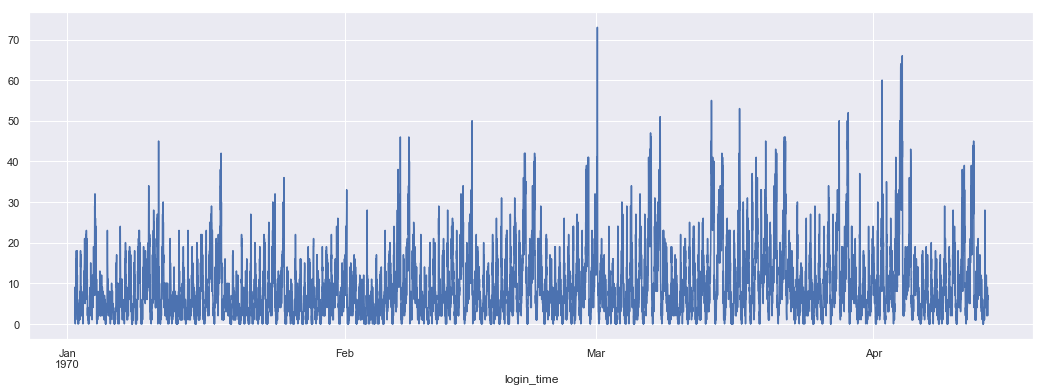

In [9]:
series=logins["login"].resample('15T').sum()
series.plot()
plt.show()

The above plot is dense. In March there appears a count that is way above the rest. This could potentially be a mistake that needs further investigation.  Replot the above using a point style instead of a connected line.( See plot below). Now we see that observation in March as being  relatively more than the other values. Also noteworthy is a line that we see in the counts between 0 and 10 counts indicating a gap in the counts around the range of 5 or 6. Also it appears that the frequency of logins per 15 minute interval have increased from January to April. 

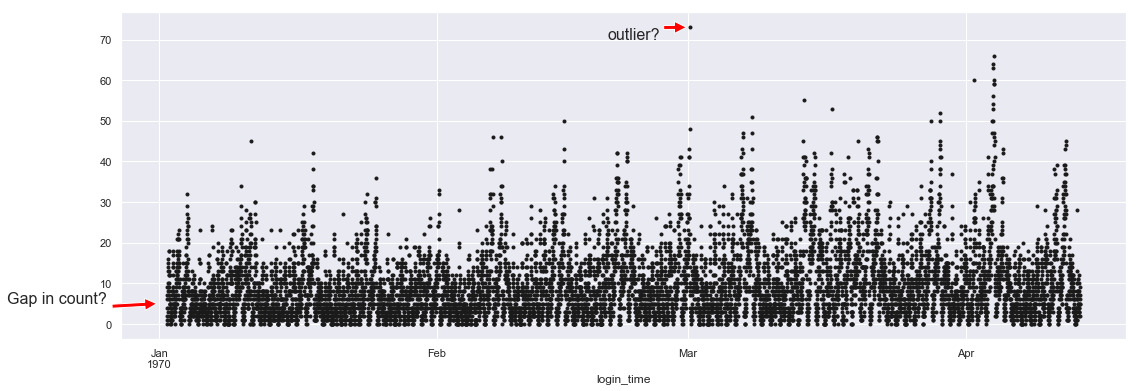

In [10]:
fig, ax = plt.subplots()
series.plot(style='k.')

ax.annotate('outlier?', xy=("1970-3-1", 73), xytext=("1970-2-20", 70), size=16, #add red arrow to show potential outlier point
            arrowprops=dict(facecolor='red', shrink=0.05))

ax.annotate('Gap in count?', xy=("1970-1-1", 5), xytext=("1969-12-15", 5), size=16,
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

Take a closer look at the point with the high value of logins in the 15 min interval. Which 15 min interval is this?

In [11]:

high_value= series[series>70]
high_value


login_time
1970-03-01 04:30:00    73
Freq: 15T, Name: login, dtype: int64

The login time interval was on March 1 at 4:30. ( 4:30-4:44 interval). Look at how many logins happened in the two adjascent intervals.

In [12]:
print(logins["login"]['1970-03-01 04:00':'1970-03-01 04:14'].count())
print(logins["login"]['1970-03-01 04:15':'1970-03-01 04:29'].count())
print(logins["login"]['1970-03-01 04:30':'1970-03-01 04:44'].count())
print(logins["login"]['1970-03-01 04:45':'1970-03-01 04:49'].count())

43
41
73
19


Look at plots by day of week and time of day to answer the following questions that come to mind.

1. Are there times of the day when there is more activity?
2. What changed are there considering day of week? Weekends? 

In [13]:
#logins.groupby([logins.index.day, logins.index.hour]).mean()


In [14]:
#make a dataframe with counts for each 15 min interval. Include a column with day of week
df = pd.DataFrame(logins["login"].resample('15T').count())
df['weekday'] = df.index.weekday  #The day of the week with Monday=0, Sunday=6
df['mth'] =df.index.month
df['day']=df['weekday']
df['hour']=df.index.hour
df['min']=df.index.minute
df.head()


login  weekday  mth  day  hour  min
login_time                                              
1970-01-01 20:00:00      2        3    1    3    20    0
1970-01-01 20:15:00      6        3    1    3    20   15
1970-01-01 20:30:00      9        3    1    3    20   30
1970-01-01 20:45:00      7        3    1    3    20   45
1970-01-01 21:00:00      1        3    1    3    21    0

In [15]:
#relabel weekdays and months

dayofweek ={ 0: 'Mon', 1:'Tue', 2: 'Wed' , 3: 'Thur', 4:'Fri' , 5: 'Sat', 6:'Sun'}

Monthname={1: 'January',  2: 'February', 3: 'March',  4: 'April'}


df['day'] = df.weekday.map(dayofweek)

df['month'] = df.mth.map(Monthname)

df.head(10)


login  weekday  mth   day  hour  min    month
login_time                                                        
1970-01-01 20:00:00      2        3    1  Thur    20    0  January
1970-01-01 20:15:00      6        3    1  Thur    20   15  January
1970-01-01 20:30:00      9        3    1  Thur    20   30  January
1970-01-01 20:45:00      7        3    1  Thur    20   45  January
1970-01-01 21:00:00      1        3    1  Thur    21    0  January
1970-01-01 21:15:00      4        3    1  Thur    21   15  January
1970-01-01 21:30:00      0        3    1  Thur    21   30  January
1970-01-01 21:45:00      4        3    1  Thur    21   45  January
1970-01-01 22:00:00      9        3    1  Thur    22    0  January
1970-01-01 22:15:00      8        3    1  Thur    22   15  January

Take a look at total number of logins per day.

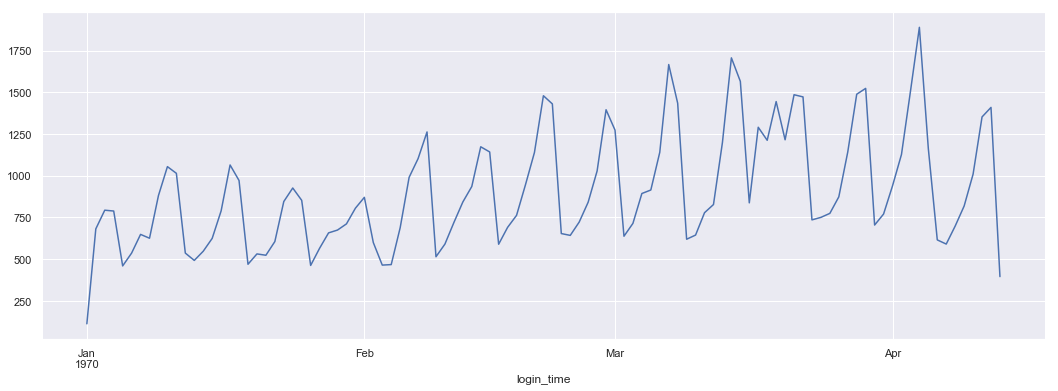

In [16]:
series_day_total=df["login"].resample('D').sum()
series_day_total.plot()

The plot above shows the peaks in the above plots happening more or less at comparable intervals. Indicating some periodic variation in the login counts by day of week. It appears that the login counts increase. peaks and drops regularly. One exception in the third peak in March when after the drop the rise in logins is rapid and indicates high counts for several days in that period. 

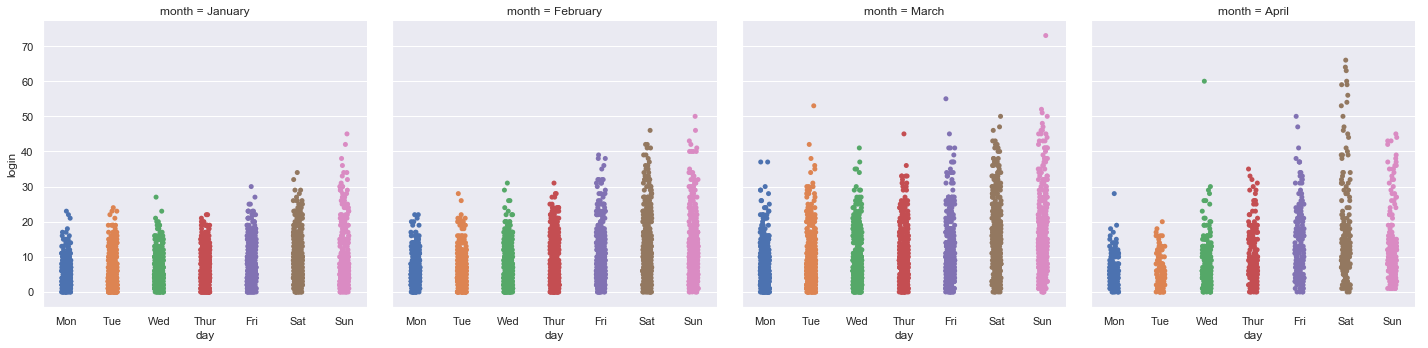

In [17]:
sum_month_weekday = sns.catplot(x='day', y='login', col ='month', data=df,
                                order=["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"])

Clearly from the above plots the count per 15 mins of logins increases from Monday to Sunday in January , February and March. The count is more on Saturdays than Sundays in April but we should also note that we have ony two weeks worth of data for April.
The increase in login counts per 15 mins intervals with day of week implies that on the weekends there are times that have a higher demand and low count intervals indicate lower demand. So we should look at the change in counts during the day.

In [36]:
import matplotlib.dates as mdates

In [60]:
day =[ 'Mon', 'Tue',  'Wed' , 'Thur', 'Fri' , 'Sat', 'Sun']


dct= {}

for i in day:
      mask = (df['day'] == i)
      dct['day_%s' %i] = df.loc[mask]   



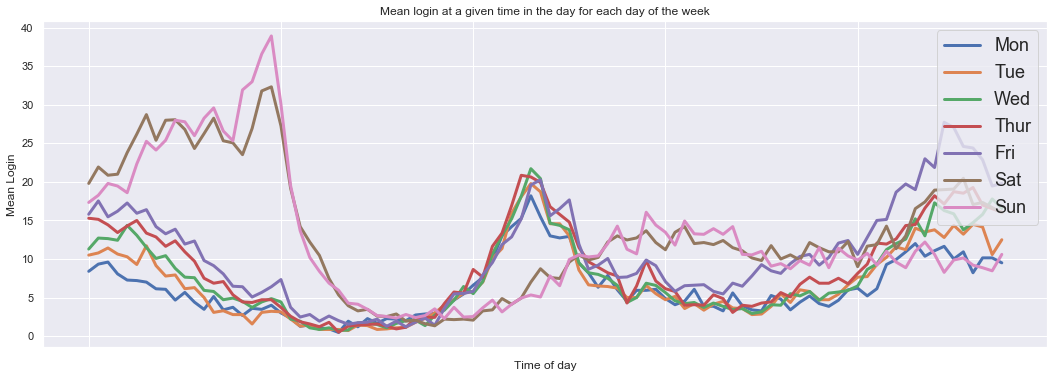

In [61]:
fig, ax = plt.subplots()
for i, (key, value) in enumerate(dct.items()):

    dct[key].groupby(['hour', 'min'])['login'].mean().plot(linewidth=3)

plt.xlabel('Time of day') 
plt.ylabel('Mean Login')
plt.title('Mean login at a given time in the day for each day of the week')
plt.legend(day, loc='upper right')

plt.show()    # need to add Xaxis ticks.

The change in Logins by hour shows that the logins for Monday through Thursday follow a similar pattern declining gradually from midnight to morning and steadily increasing with a peak at mid day to decline again and rise later in the day. Saturday and Sunday are different in that the logins increase from midnight peaking in the early morning hours and declining sharply to increase again around evening and with SAT increasing later whilst Sunday does not. Friday follows the weekeday trend from midnight to midday but picks up and has the highest peak as night falls. These patterns agree well with what woudl be expected. During the weekday there is not much demand during the work hours, increasing at lunch time and declining again until after work. Weekends the demand is high at night time and picks up again later in the day. Friday early hours follows the weekday trend but the later hours follows the weekend trend



### Part 2 ‐ Experiment and metrics design
**qst:
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

**Answer:**
A key measure of success of this experiment would be if the number of trips that a driver from one side of the bridge
makes across to the other side is significantly more when the tolls are reimbursed versus when tolls are not reimbursed. 
The total number of trips per day the driver partners make across the toll bridge to the opposite area of operation could be obtained by keeping track of the tolls incurred by the driver when reimbursed as well as not reimbursed
       
      Total number of trips to the opposite side per day = Total amount paid in tolls per day/ two-way toll per crossing.
       
 The reason for choosing this metric is that it is:
 1. Measurable and Objective
 2. Easily reported
 3. Directly connected to what is hypothesised as the reason for the drivers to limit themselves to operate in one area only.  
       
**qst:
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on how you will implement the experiment what statistical test(s) you will conduct to verify the significance of the observation, how you would interpret the results and provide recommendations to the city operations team along with any caveats.**
       
**Answer:**

  1. Choose a minimum of two periods of time. eg. Two months or Two Bi-Weekly periods. In choosing this time period it would be necessary that it would be representative of the normal conditions one would encounter ( avoiding holiday periods etc) and covers the full cycle of variation present. ( Not have the first period be the weekend and the second period be the weekday)
  
  2. Use Stratified random allocation of drivers to either Group A or Group B. The stratification would be by the area they
     usually operate on. 
      
  3. The treatments would be Reimbursed/ Not reimbursed
     Drivers in Group A would be reimbursed in the first period and not reimbursed in the second period. 
     Drivers in Group B would not be reimbursed in the first period but reimbursed in the second period.
     ( This switch is to reduce the effect of carryover effect of period 1 activit to period 2  which would be balanced out by         doing this)
      
      
     | Group |  Period 1      |  Period 2      | 
     |-----------------------------------------|
     |  A    | Reimbursed     | Not Reimbursed |
     |  B    | Not Reimbursed | Reimbursed     |
  
  4. The Response Variable would be the count of two way tolls incurred by each driver per day.
  
  5. Hypothesis : 
  
     Null       : There is no change in the amount of tolls when Reimbursed vs Not Reimbursed.
     
     Alternative: There is an increase in the amount of tolls for the reimbursed Period vs the Not reimbursed  Period.
                  
                  
  6. Statistical Analysis: 
     The difference in the toll counts between (Reimbursed - not Reimbursed) would be obtained for each 
     driver. If the number of drivers participating less than 30 a permutaition test or if the numbers are larger 
     a one sided paired T test could be carried out to test for evidence for rejecting the null hypothesis. 
   
  7. If there is a statistical significance we should also consider if the difference is practically significant. 
   
  8. Basically this experiment would tell us if the toll is a deterrent to the drivers going across to the other side.
     There could be other reasons a driver partner may limit themselves to one region. eg Familiarity of the region.
     The time period chosen may impact the results. Several repetitions over the year would remove any biases.
     
   
   
                  
      


### Part 3:

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice).
What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [62]:
#Load json info
with open('ultimate_data_challenge.json') as f:
    ultimate = json.load(f)

#Convert to dataframe
ultimate = pd.DataFrame(ultimate)

#Convert the time series to datetimes appropriately
ultimate.signup_date = pd.to_datetime(ultimate.signup_date)
ultimate.last_trip_date = pd.to_datetime(ultimate.last_trip_date)

ultimate.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False         50.0  
2                       3                False        100.0  
3                       9                 True         80.0  
4                      14                False         82.4

In [65]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


From above we can see that we have
1.  6 numeric( floating point) variables ( avg_dist, avg_rating_by_driver, avg_rating_of_driver, avg_surge, surge_pct,trips_in_first_30_Days and weekday_pct).
2.  3 categorical features: city , phone, ultimate_black_user.
3.  2 datetime features last_trip_date and trips_in_first_30_days. These two can be used to figure out the response if the rider was active in the last month before the 6th month after signup.
                            

In [66]:
ultimate.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
std       19.958811                3.792684     37.081503  
min        0.000000                0.000000      0.000000  
25%        0.000000                0.000000     33.300000  
50%        0.000000                1.000000     66.700000  
75%        8.600000                3.000000    100.000000  
max      100.000000              125.000000    100.000000

In [67]:
ultimate[['signup_date', 'last_trip_date']].describe()

signup_date       last_trip_date
count                 50000                50000
unique                   31                  182
top     2014-01-18 00:00:00  2014-06-29 00:00:00
freq                   2948                 2036
first   2014-01-01 00:00:00  2014-01-01 00:00:00
last    2014-01-31 00:00:00  2014-07-01 00:00:00

### Create Response Variable Active_Status:
The data are from a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; a user  is considered to be retained if they were “active” (i.e. took a trip) in the preceding 30 days.

All users who were active within 30 days prior to the date the data was pulled would be considered active and those who were not 
would be considered non active. The variable last_trip_date could be used to determine this. 
We first need to get the latest date for this variable. We would consider this data to be the date when the data was pulled. 
All users whose last_trip_date falls within 30 days of this date would be considered active indicated by a 1 and 0 otherwise.

In [94]:
ultimate['last_trip_date'].max()


Timestamp('2014-07-01 00:00:00')

In [95]:

active_status = []
for i in range(len(ultimate)):
   
    end_date = pd.Timestamp(ultimate['last_trip_date'].max())
    
    prior_30 = end_date - pd.Timedelta('30D') #set point 30 days prior
    
    if prior_30 <= pd.Timestamp(ultimate['last_trip_date'][i]) <= end_date:
        active_status.append(1) # If active, set active_status to 1
    else:
        active_status.append(0)
ultimate["active_status"] =active_status

In [96]:
ultimate[['signup_date', 'last_trip_date', "active_status"]].head(20)

signup_date last_trip_date  active_status
0   2014-01-25     2014-06-17              1
1   2014-01-29     2014-05-05              0
2   2014-01-06     2014-01-07              0
3   2014-01-10     2014-06-29              1
4   2014-01-27     2014-03-15              0
5   2014-01-09     2014-06-06              1
6   2014-01-24     2014-01-25              0
7   2014-01-28     2014-01-29              0
8   2014-01-21     2014-02-01              0
9   2014-01-03     2014-01-05              0
10  2014-01-13     2014-05-30              0
11  2014-01-06     2014-01-10              0
12  2014-01-15     2014-03-12              0
13  2014-01-29     2014-06-08              1
14  2014-01-27     2014-01-28              0
15  2014-01-15     2014-01-16              0
16  2014-01-11     2014-06-28              1
17  2014-01-12     2014-07-01              1
18  2014-01-28     2014-06-24              1
19  2014-01-02     2014-06-03              1

In [97]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active_status             50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


Missing Values: There are missing values for avg_rating_by driver, avg_rating_of_driver and phone as the number of entries is 
less than 50000.
The number of missing values for phones is very small and could be dropped. The average ratings though may be important and some thought should be put into handling these values. 

In [103]:
# number of missing values
print('numberof missing values for avg_rating_by_driver: {}'.format(50000-49799))
print('numberof missing values for avg_rating__of_driver: {}'.format(50000-41878))
print('numberof missing values for phone: {}'.format(50000-49604))

numberof missing values for avg_rating_by_driver: 201
numberof missing values for avg_rating__of_driver: 8122
numberof missing values for phone: 396


In [104]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set(color_codes=True)
%matplotlib inline

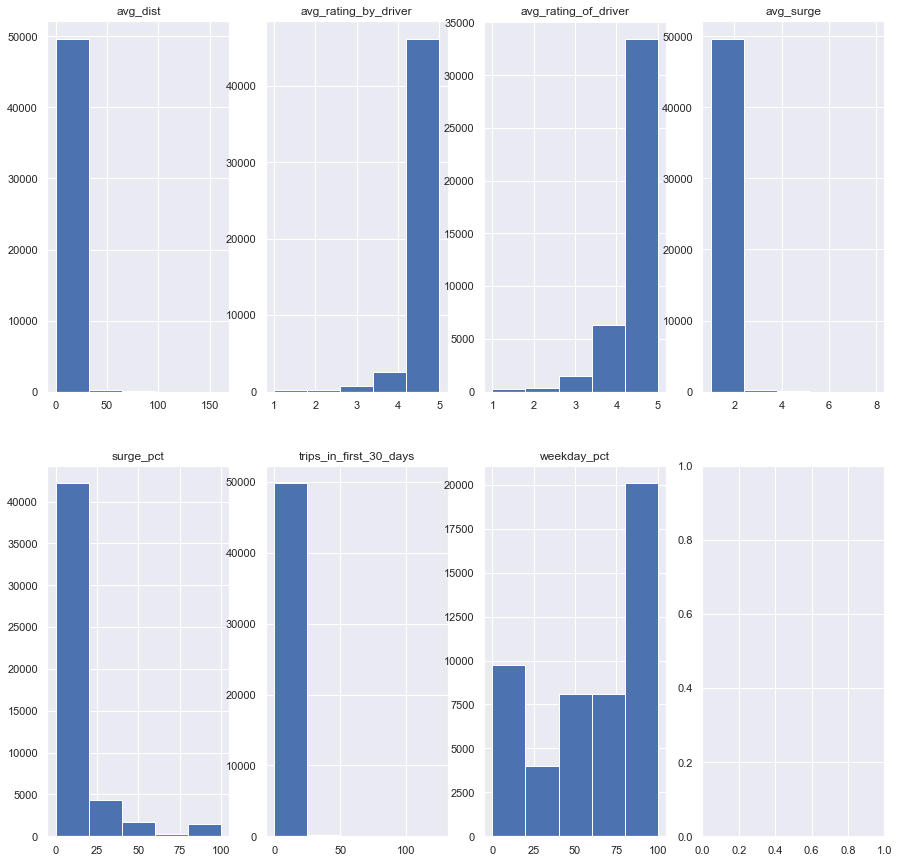

In [105]:
continous = ["avg_dist", "avg_rating_by_driver", "avg_rating_of_driver", "avg_surge", 
             "surge_pct", "trips_in_first_30_days", "weekday_pct"]


 
f, axes = plt.subplots(2, 4, figsize=(15,15)) 
axes=axes.ravel()
for i, var in enumerate(continous):

    axes[i].hist(ultimate[var].dropna(), bins=5)
    axes[i].set_title(var)
    
plt.show()


For the Features that have a high frequency in the low values, replot by specifying bin width to take a look at the distribution 
of the feature values. 

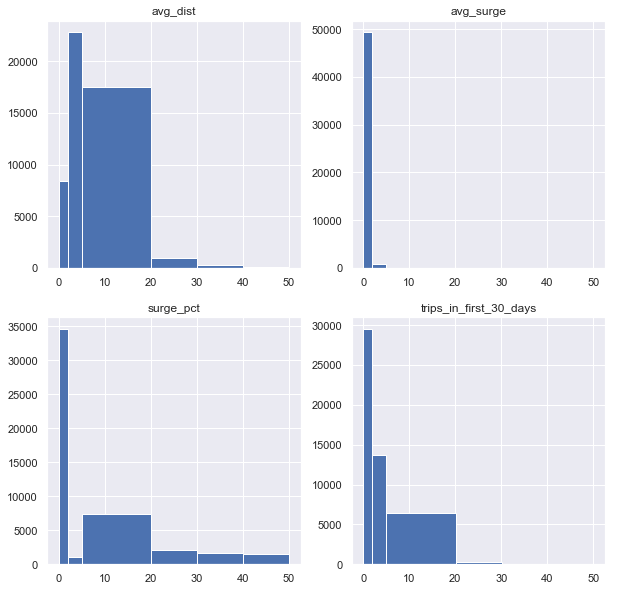

In [106]:
continous_50 = ["avg_dist",  "avg_surge", 
             "surge_pct", "trips_in_first_30_days"]

bins = [0, 2, 5, 20.1, 30.1, 40.1, 50.1]
 
f, axes = plt.subplots(2, 2, figsize=(10,10)) 
axes=axes.ravel()
for i, var in enumerate(continous_50):

    axes[i].hist(ultimate[var].dropna(), bins=bins)
    axes[i].set_title(var)
    
plt.show()


 We will have to scale the features as the rating data range from 0-5 and the distance travelled >150.

In [107]:
# look at the number of unique categories for each categorical feature
for col_name in ultimate.columns:
    if ultimate[col_name].dtypes in['object', 'bool']:
        unique_cat = len(ultimate[col_name].unique())
        print(" '{col_name}' : {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        

 'city' : 3 unique categories
 'phone' : 3 unique categories
 'ultimate_black_user' : 2 unique categories


 ##### What fraction of the observed users were retained? 

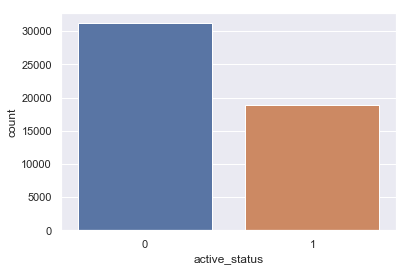

In [108]:
sns.countplot(data=ultimate,
                  x ='active_status')

In [109]:
percent_activestatus = (ultimate['active_status'].value_counts()/len(ultimate['active_status'])) *100
percent_activestatus

0    62.392
1    37.608
Name: active_status, dtype: float64

The percent retained is  37.61%

### Predictive Strength of each feature on retention

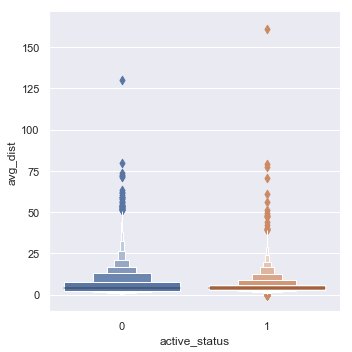

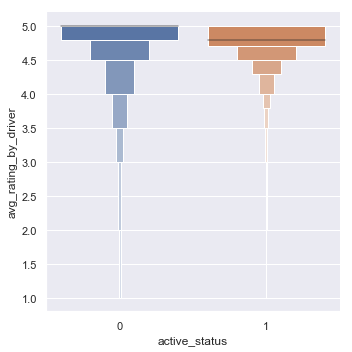

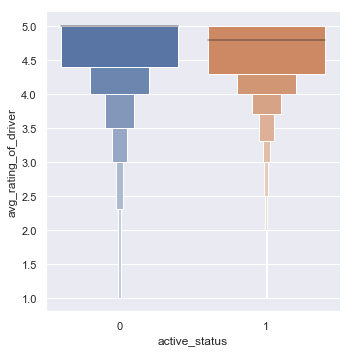

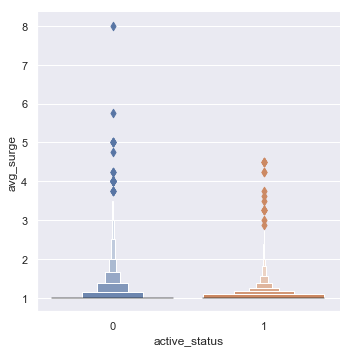

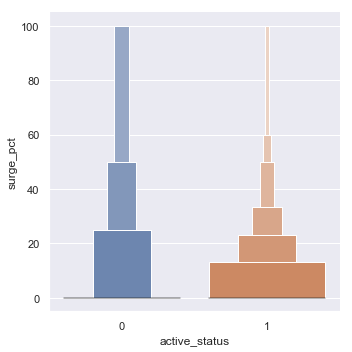

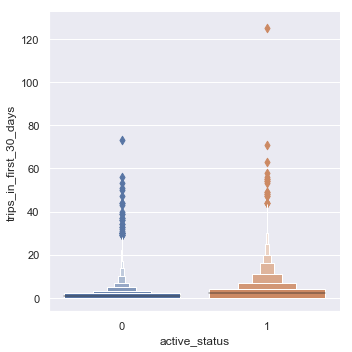

In [112]:
cols_to_plot1= ["avg_dist", "avg_rating_by_driver", "avg_rating_of_driver", "avg_surge", 
             "surge_pct", "trips_in_first_30_days"] 
cols_to_plot2= ["weekday_pct", "city", "phone",'ultimate_black_user']

for i in cols_to_plot1:
    g = sns.catplot(x='active_status', y=i, kind='boxen',
                   data=ultimate
                    
                   )

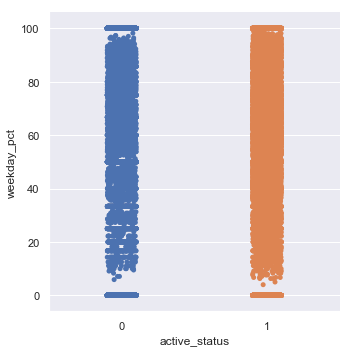

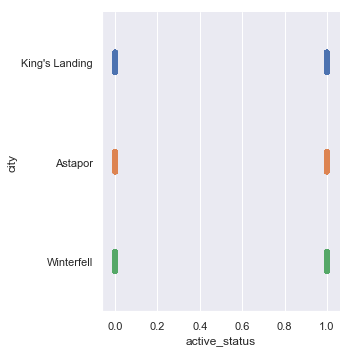

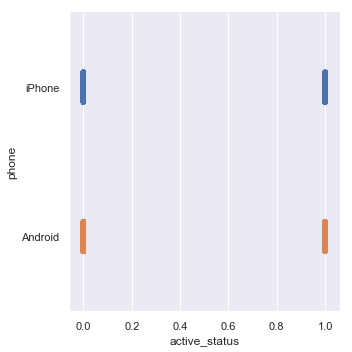

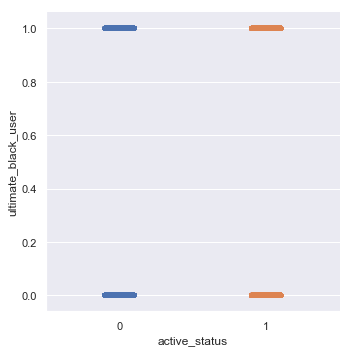

In [113]:
cols_to_plot2= ["weekday_pct", "city", "phone",'ultimate_black_user']
    
for i in cols_to_plot2:
    g = sns.catplot(x='active_status', y=i, 
                   data=ultimate
                    
                   )

Just by looking at the above plots most of the features have similar distribution for active status 0( not retained) vs activ e status=1( retained). The ratings by the drive and about the driver seem to be different in there appears more lower ratings for active status =0 or those who were not retained, which makes sense. 


In [114]:
#drop phone cateogry
df = ultimate.drop(['signup_date', 'last_trip_date'], axis = 1)
#encode ultimate black user 1 = True | 0 = False

df.ultimate_black_user = ultimate.ultimate_black_user.astype('category').cat.codes
#encode phone iphone =1 = True | 0 = False

df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city    phone  surge_pct  trips_in_first_30_days  \
0  King's Landing   iPhone       15.4                       4   
1         Astapor  Android        0.0                       0   
2         Astapor   iPhone        0.0                       3   
3  King's Landing   iPhone       20.0                       9   
4      Winterfell  Android       11.8                      14   

   ultimate_black_user  weekday_pct  active_status  
0                    1         46.2              1  
1                    0         50.0              0  
2                    0        100.0              0  
3                    1         80.0              1  
4                    0         82.4              0

### Model Building



In [ ]:
x_data = df.drop('active_status', axis = 1)


y_data = df.active_status

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

#### Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':[100,200],
              'max_leaf_nodes':[3,5,7]}

In [ ]:
rf_clf = RandomForestClassifier()

In [ ]:
rf_cv = GridSearchCV(rf_clf, param_grid = param_grid, cv=5)

In [ ]:
rf_cv.fit(X_train, y_train)

In [ ]:
rf_preds = rf_cv.predict(X_test)

In [ ]:
rf_accuracy = accuracy_score(y_test, rf_preds)

In [ ]:
print(classification_report(y_test, rf_preds))
print('Test Accuracy: {}'.format(rf_accuracy))